# Машинное обучение, ФКН ВШЭ

## Практическое задание (Бонус). Разложение ошибки на смещение и разброс

### Общая информация

Дата выдачи: 12.12.2023

Мягкий дедлайн: 23:59MSK 24.12.2023

Жесткий дедлайн: 23:59MSK 24.12.2023

### Оценивание и штрафы
Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за работу — 6 баллов.

Сдавать задание после указанного срока сдачи нельзя. При выставлении неполного балла за задание в связи с наличием ошибок на усмотрение проверяющего предусмотрена возможность исправить работу на указанных в ответном письме условиях.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов (подробнее о плагиате см. на странице курса). Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке.

### Формат сдачи
Задания сдаются через систему anytask. Посылка должна содержать:
* Ноутбук homework-practice-07-Username.ipynb

Username — ваша фамилия и имя на латинице именно в таком порядке

### О задании

В этом задании вам предстоит воспользоваться возможностями бутстрапа для оценки смещения и разброса алгоритмов машинного обучения. Делать мы это будем на данных boston:

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

load_boston не поддерживается в версиях sklearn с 1.2, поэтому скачаем данные напрямую

In [10]:

data_url = "http://lib.stat.cmu.edu/datasets/boston"
raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
X = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
y = raw_df.values[1::2, 2]

In [11]:
X.shape, y.shape

((506, 13), (506,))

### Вычисление bias и variance с помощью бутстрапа
На лекции была выведено следующая формула, показывающая, как можно представить ошибку алгоритма регрессии в виде суммы трех компонент:
$$
L(\mu) = 
    \mathbb{E}_{x, y}\bigl[\mathbb{E}_{X}\bigl[ (y - \mu(X)(x))^2 \bigr]\bigr] = 
$$
$$
    \underbrace{\mathbb{E}_{x, y}\bigl[(y - \mathbb{E}[y|x] )^2\bigr]}_{\text{шум}} + \underbrace{\mathbb{E}_{x}\bigl[(\mathbb{E}_{X}[\mu(X)(x)] - \mathbb{E}[y|x] )^2\bigr]}_{\text{смещение}} +
    \underbrace{\mathbb{E}_{x}\bigl[\mathbb{E}_{X}\bigl[(\mu(X)(x) - \mathbb{E}_{X}[\mu(X)(x)] )^2\bigr]\bigr]}_{\text{разброс}},
$$
* $\mu(X)$ — алгоритм, обученный по выборке $X = \{(x_1, y_1), \dots (x_\ell, y_\ell)\}$;
* $\mu(X)(x)$ — ответ алгоритма, обученного по выборке $X$, на объекте $x$;
* $\mathbb{E}_{X}$ — мат. ожидание по всем возможным выборкам;
* $\mathbb{E}_{X}[\mu(X)(x)]$ — "средний" ответ алгоритма, обученного по всем возможным выборкам $X$, на объекте $x$.
    
С помощью этой формулы мы можем анализировать свойства алгоритма обучения модели $\mu$, если зададим вероятностную модель порождения пар $p(x, y)$.

В реальных задачах мы, конечно же, не знаем распределение на парах объект - правильный ответ. Однако у нас есть набор семплов из этого распределения (обучающую выборка), и мы можем использовать его, чтобы оценивать математические ожидания. Для оценки мат. ожиданий по выборкам мы будем пользоваться бутстрэпом - методом генерации "новых" выборок из одной с помощью выбора объектов с возвращением. Разберем несколько шагов на пути к оценке смещения и разброса.

#### Приближенное вычисление интегралов
На занятиях мы разбирали примеры аналитического вычисления смещения и разброса нескольких алгоритмов обучения. Для большинства моделей данных и алгоритмов обучения аналитически рассчитать математические ожидания в формулах не удастся. Однако мат. ожидания можно оценивать приближенно. Чтобы оценить математическое ожидание $\mathbb{E}_{\bar z} f(\bar z)$ функции от многомерной случайной величины $\bar z = (z_1, \dots, z_d)$, $\bar z \sim p(\bar z)$, можно сгенерировать выборку из распределения $p(\bar z)$ и усреднить значение функции на элементах этой выборки:
$$\mathbb{E}_{\bar z} f(z) = \int f(\bar z) p(\bar z) d \bar z \approx \frac 1 m \sum_{i=1}^m f(\bar z_i), \, \bar z_i \sim p(\bar z), i = 1, \dots, m.$$

Например, оценим $\mathbb{E}_z z^2,$ $z \sim \mathcal{N}(\mu=5, \sigma=3)$ (из теории вероятностей мы знаем, что
$\mathbb{E}_z z^2 = \sigma^2 + \mu^2 = 34$):

In [9]:
z = np.random.normal(loc=5, scale=3, size=1000)
(z**2).mean()

34.59576652192569

#### Оценивание $\mathbb{E}_{x, y}$
Оценить мат. ожидания по $x$ и по $x, y$, встречающиеся во всех трех компонентах разложения, несложно, потому что у нас есть выборка объектов из распределения данных $p(x, y)$:
$$ \mathbb{E}_{x} f(x) \approx \frac 1 N \sum_{i=1}^N f(x_i), \quad
\mathbb{E}_{x, y} f(x, y) \approx \frac 1 N \sum_{i=1}^N f(x_i, y_i),$$
где $N$ - число объектов в выборке, $\{(x_i, y_i)\}_{i=1}^N$ - сама выборка. 

#### Оценивание $\mathbb{E}_X$ с помощью бутстрапа
Чтобы оценить мат. ожидание по $X$, нам понадобится выборка из выборок:
$$\mathbb{E}_X f(X) \approx \frac 1 s \sum_{j=1}^s f(X_j),$$
где $X_j$ - $j$-я выборка. Чтобы их получить, мы можем воспользоваться бутстрапом - методом генерации выборок на основе выбора объектов с возвращением. Чтобы составить одну выборку, будем $N$ раз выбирать индекс объекта $i \sim \text{Uniform}(1 \dots N)$ и добавлять $i$-ю пару (объект, целевая переменная) в выборку. В результате в каждой выборке могут появиться повторяющиеся объекты, а какие-то объекты могут вовсе не войти в некоторые выборки.

#### Итоговый алгоритм оценки смещения и разброса алгоритма $a$
1. Сгенерировать $s$ выборок $X_j$ методом бутстрапа.
1. На каждой выборке $X_j$ обучить алгоритм $a_j$.
1. Для каждой выборки $X_j$ определить множество объектов $T_j$, не вошедших в нее (out-of-bag). Вычислить предсказания алгоритма $a_j$ на объектах $T_j$. 

Поскольку у нас есть только один ответ для каждого объекта, мы будем считать шум равным 0, а $\mathbb{E}[y|x]$ равным имеющемуся правильному ответу для объекта $x$. 

Итоговые оценки:
* Смещение: для одного объекта - квадрат разности среднего предсказания и правильного ответа. Среднее предсказание берется только по тем алгоритмам $a_j$, для которых этот объект входил в out-of-bag выборку $T_j$. Для получения общего смещения выполнить усреденение смещений по объектам.
* Разброс: для одного объекта - выборочная дисперсия предсказаний алгоритмов $a_j$, для которых этот объект входил в out-of-bag выборку $T_j$. Для получения общего разброса выполнить усреденение разбросов по объектам.
* Ошибка $L$: усреднить квадраты разностей предсказания и правильного ответа по всем выполненным предсказаниям для всех объектов.

В результате должно получиться, что ошибка приблизительно равна сумме смещения и разброса!

Алгоритм также вкратце описан по [ссылке](https://web.engr.oregonstate.edu/~tgd/classes/534/slides/part9.pdf) (слайды 19-21).

__1. (1.5 балла)__

Реализуйте описанный алгоритм. Обратите внимание, что если объект не вошел ни в одну из out-of-bag выборок, учитывать его в вычислении итоговых величин не нужно. Как обычно, разрешается использовать только один цикл - по выборкам (от 0 до num_runs-1).

In [76]:
def compute_biase_variance(regressor, X, y, num_runs=1000):
    """
    :param regressor: sklearn estimator with fit(...) and predict(...) method
    :param X: numpy-array representing training set ob objects, shape [n_obj, n_feat]
    :param y: numpy-array representing target for training objects, shape [n_obj]
    :param num_runs: int, number of samples (s in the description of the algorithm)

    :returns: bias (float), variance (float), error (float)
    each value is computed using bootstrap
    """
    n = len(X)
    error_sum = 0
    predictions_sum = np.zeros(n)
    predictions_squared_sum = np.zeros(n)
    inclusion_count = np.zeros(n)

    for _ in range(num_runs):
        indexes = np.random.choice(n, n, replace=True)
        X_bootstrap = X[indexes]
        y_bootstrap = y[indexes]
        out_of_bag = ~np.isin(np.arange(n), indexes)

        regressor.fit(X_bootstrap, y_bootstrap)
        y_pred = regressor.predict(X[out_of_bag])

        predictions_sum[out_of_bag] += y_pred
        predictions_squared_sum[out_of_bag] += np.power(y_pred, 2)
        inclusion_count[out_of_bag] += 1

        error_sum += np.sum(np.power(y[out_of_bag] - y_pred, 2))

    error = error_sum / np.sum(inclusion_count)
    bias = np.mean(np.power(predictions_sum[inclusion_count > 0] / inclusion_count[inclusion_count > 0] - y[inclusion_count > 0], 2))
    variance = np.mean(predictions_squared_sum[inclusion_count > 0] / inclusion_count[inclusion_count > 0] - np.power(predictions_sum[inclusion_count > 0] / inclusion_count[inclusion_count > 0], 2))

    return bias, variance, error



__2. (0 баллов)__

Оцените смещение, разброс и ошибку для трех алгоритмов с гиперпараметрами по умолчанию: линейная регрессия, решающее дерево, случайный лес.

In [77]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

bias, var, error_L = compute_biase_variance(LinearRegression(), X, y, len(X))
print(bias, var, error_L)
bias, var, error_L = compute_biase_variance(DecisionTreeRegressor(), X, y, len(X))
print(bias, var, error_L)
bias, var, error_L = compute_biase_variance(RandomForestRegressor(), X, y, len(X))
print(bias, var, error_L)



23.81970589813981 0.951708105660722 24.522031339498195
10.311086108873306 12.870224103294301 23.300621640321445
10.565477347420204 2.248556241806447 12.985497655853413


__3. (0.5 баллов)__
Проанализируйте полученный результат. Согласуются ли полученные результаты с теми, что мы обсуждали на занятиях (с комментарием)?

__Your answer here:__

Кажется, что вполне согласуется. Получилось, что у линейной регрессии самый большой bias, но самый маленький разброс 

У дерева bias примерно такой же, как и у леса, но большой разброс

У леса bias такой же, как и у дерева, но мы уменьшили разброс в сравнении с деревом

Также видим, что у линрега самая большая ошибка, а у леса самая маленькая, что тоже логично.

Также можно заметить, что мы получили, что bias+variance ~= error, что тоже согласуется с нашей теорией.



__4. (0.5 баллов)__
Постройте бэггинг над всеми тремя моделями (линейная регрессия, решающее дерево, случайный лес). Вспомните обсуждение с лекции о том, во сколько раз в теории бэггинг уменьшает разброс базового алгоритма. Выполняется ли это в ваших экспериментах? Если нет, поясните, почему.

__Your answer here:__

In [73]:
from sklearn.ensemble import BaggingRegressor

bias, var, error_L = compute_biase_variance(BaggingRegressor(estimator=LinearRegression(), n_jobs=-1), X, y, len(X))
print(bias, var, error_L)
bias, var, error_L = compute_biase_variance(BaggingRegressor(estimator=DecisionTreeRegressor(), n_jobs=-1), X, y, len(X))
print(bias, var, error_L)
bias, var, error_L = compute_biase_variance(BaggingRegressor(estimator=RandomForestRegressor(), n_jobs=-1), X, y, len(X))
print(bias, var, error_L)

23.738834040093835 1.0327629492323576 24.622430535517474
10.421937539187157 3.351769581935105 13.738346535621313
11.568379395115617 1.4179379884533085 12.954919815045441


### Визуализация предсказаний базовых алгоритмов бэггинга

В материалах лекций можно найти изображение, похожее на мишень - визуализация алгоритмов с разным смещением и разным разбросом. В центре "мишени" - правильный ответ, а "попадания" - предсказания алгоритмов, обученных по разным выборкам. Построим похожее изображение на наших данных для трех алгоритмов. Наши "мишени" будут одномерными, потому что мы решаем задачу одномерной регрессии.

__5. (1.5 балла)__

Реализуйте функцию plot_predictions. Она должна выполнять следующие действия:
1. Случайно выбрать num_test_objects пар объект-целевая переменная из выборки X, y. Получится две выборки: маленькая X_test, y_test (выбранные тестовые объекты) и X_train, y_train (остальные объекты).
1. Сгенерировать num_runs выборок методом бутстарапа из X_train, y_train. На каждой выборке обучить алгоритм regressor и сделать предсказания для X_test.
1. Нарисовать scatter-график. По оси абсцисс - объекты тестовой выборки (номера от 0 до num_test_objects-1), по оси ординат - предсказания. В итоге получится num_test_objects столбиков с точками. Для каждого тестового объекта надо отметить одним цветом все предсказания для него, а также черным цветом отметить правильный ответ.
1. Подпишите оси и название графика (аргумент title).

In [149]:
import seaborn as sns


def plot_predictions(regressor, X, y, num_runs=100, num_test_objects=10, title=""):
    """
    plot graphics described above
    """
    n = len(X)
    test_indexes = np.random.choice(n, num_test_objects, replace=False)
    X_test, y_test = X[test_indexes], y[test_indexes]
    train_indexes = ~np.isin(np.arange(n), test_indexes)
    X_train, y_train = X[train_indexes], y[train_indexes]

    predictions = []
    for _ in range(num_runs):
        bs_indexes = np.random.choice(len(X_train), len(X_train), replace=True)
        X_train_bs, y_train_bs = X_train[bs_indexes], y_train[bs_indexes]

        regressor.fit(X_train_bs, y_train_bs)
        y_pred = regressor.predict(X_test)
        predictions.append(y_pred)

    predictions = np.array(predictions)
    sns.scatterplot(x=np.repeat(np.arange(0, num_test_objects), num_runs), y=predictions.T.flatten(), c='orange', label='predictions')
    sns.scatterplot(x=np.arange(0, num_test_objects), y=y_test, c='black', marker='*', s=500, label='groud truth')
    plt.xlabel('Number of object')
    plt.ylabel('predicions')
    plt.title(f'Predictions for {title}')
    plt.legend()
    plt.grid()
    # plt.show()


__6. (0 баллов)__

Нарисуйте графики для линейной регрессии, решающего дерева и случайного леса. Нарисуйте три графика в строчку (это можно сделать с помощью plt.subplot) с одинаковой осью ординат (это важно для понимания масштаба разброса у разных алгоритмов):

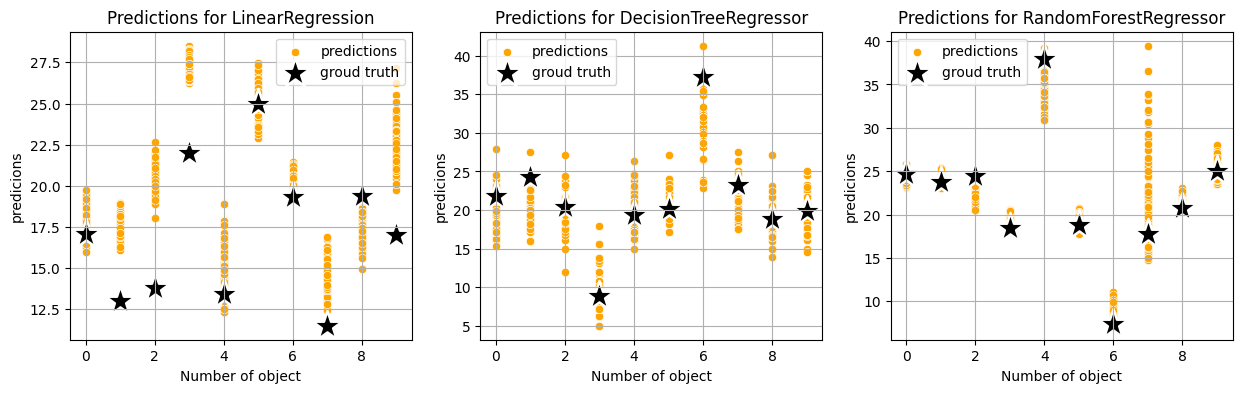

In [150]:
plt.figure(figsize=(15, 4))
plt.subplot(1, 3, 1)
plot_predictions(LinearRegression(), X, y, title='LinearRegression')
plt.subplot(1, 3, 2)
plot_predictions(DecisionTreeRegressor(), X, y, title='DecisionTreeRegressor')
plt.subplot(1, 3, 3)
plot_predictions(RandomForestRegressor(), X, y, title='RandomForestRegressor')
plt.show()


__7. (0.5 баллов)__

Для каждого графика прокомментируйте, как он характеризует смещение и разброс соответствующего алгоритма. 

__Your answer here:__

Видим, что линейная регрессия имеет небольшой разброс но большое смещение

Дерево имеет небольшое смещение и большой разброс 

Лес имеет небольшое смещение и маленький разброс

В целом все ровно так, как и говорилось на лекциях 

### Изменение bias и variance при изменении гиперпараметров

__8. (0 баллов)__

Постройте графики зависимости смещения и разброса от гиперпараметров решающего дерева max_depth (от 1 до 10) и max_features (от 1 до X.shape[1]):

In [152]:
max_features_grid = np.arange(1, X.shape[1])
max_depth_grid = np.arange(1, 10)

biases_max_features = []
vars_max_features = []

biases_max_depth = []
vars_max_depth = []

for max_features in max_features_grid:
    bias, var, _ = compute_biase_variance(DecisionTreeRegressor(max_features=max_features), X, y)
    biases_max_features.append(bias)
    vars_max_features.append(var)

for max_depth in max_depth_grid:
    bias, var, _ = compute_biase_variance(DecisionTreeRegressor(max_depth=max_depth), X, y)
    biases_max_depth.append(bias)
    vars_max_depth.append(var)



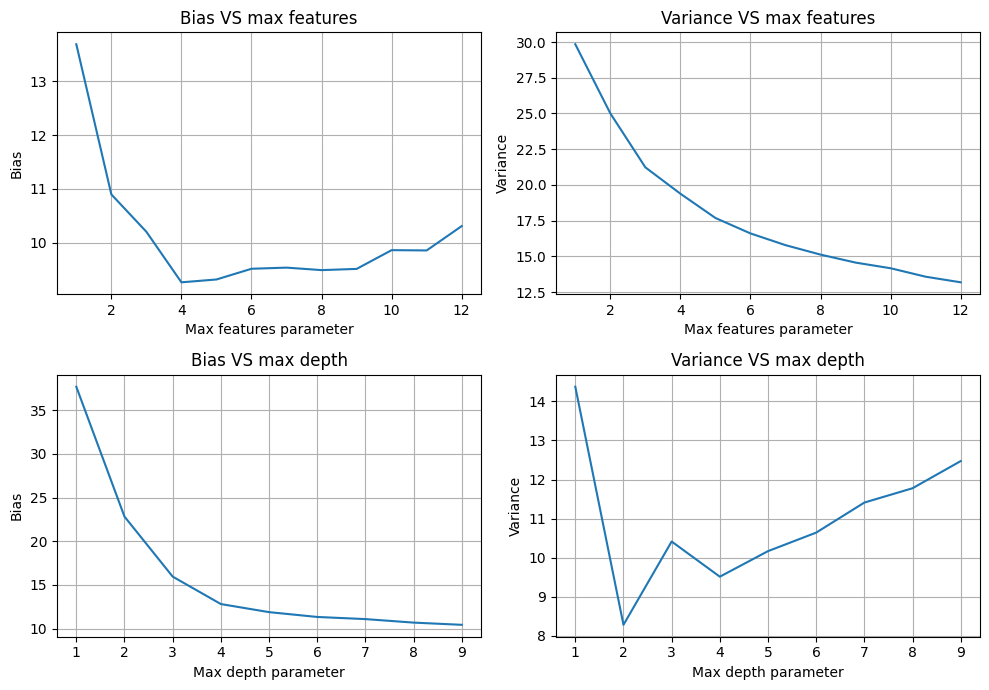

In [168]:
plt.figure(figsize=(10, 7))
plt.subplot(2, 2, 1)
sns.lineplot(x=max_features_grid, y=biases_max_features)
plt.xlabel('Max features parameter')
plt.ylabel('Bias')
plt.grid()
plt.title('Bias VS max features')
plt.subplot(2, 2, 2)
sns.lineplot(x=max_features_grid, y=vars_max_features)
plt.xlabel('Max features parameter')
plt.ylabel('Variance')
plt.title('Variance VS max features')
plt.grid()
plt.tight_layout()

plt.subplot(2, 2, 3)
sns.lineplot(x=max_depth_grid, y=biases_max_depth)
plt.xlabel('Max depth parameter')
plt.title('Bias VS max depth')
plt.ylabel('Bias')
plt.grid()
plt.subplot(2, 2, 4)
sns.lineplot(x=max_depth_grid, y=vars_max_depth)
plt.xlabel('Max depth parameter')
plt.title('Variance VS max depth')
plt.ylabel('Variance')
plt.tight_layout()

plt.grid()
plt.show()

__9. (0 баллов)__

Постройте графики зависимости смещения и разброса от n_estimators (по сетке 2**np.arange(1, 10)) для случайного леса и градиентного бустинга:

In [173]:
from sklearn.ensemble import GradientBoostingRegressor


n_estimators_grid = 2 ** np.arange(1, 10)
biases = []
vars = []

biases_boost = []
vars_boost = []

for n in n_estimators_grid:
    bias, var, _ = compute_biase_variance(RandomForestRegressor(n_estimators=n), X, y)
    biases.append(bias)
    vars.append(var)

    bias, var, _ = compute_biase_variance(GradientBoostingRegressor(n_estimators=n), X, y)
    biases_boost.append(bias)
    vars_boost.append(var)

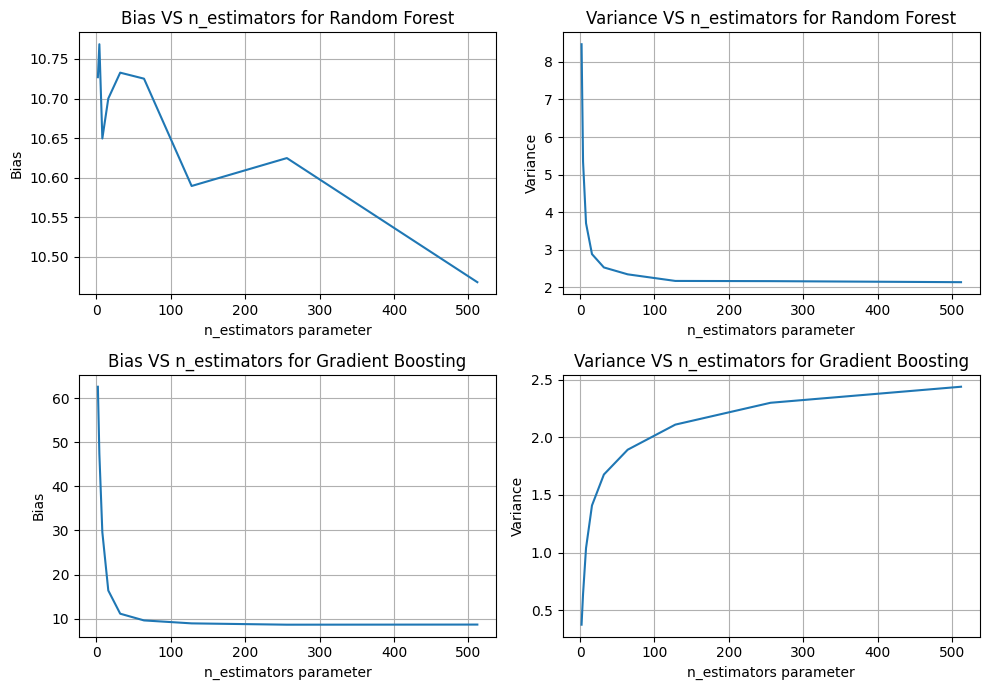

In [174]:
plt.figure(figsize=(10, 7))
plt.subplot(2, 2, 1)
sns.lineplot(x=n_estimators_grid, y=biases)
plt.xlabel('n_estimators parameter')
plt.ylabel('Bias')
plt.grid()
plt.title('Bias VS n_estimators for Random Forest')
plt.subplot(2, 2, 2)
sns.lineplot(x=n_estimators_grid, y=vars)
plt.xlabel('n_estimators parameter')
plt.ylabel('Variance')
plt.title('Variance VS n_estimators for Random Forest')
plt.grid()
plt.tight_layout()

plt.subplot(2, 2, 3)
sns.lineplot(x=n_estimators_grid, y=biases_boost)
plt.xlabel('n_estimators parameter')
plt.title('Bias VS n_estimators for Gradient Boosting')
plt.ylabel('Bias')
plt.grid()
plt.subplot(2, 2, 4)
sns.lineplot(x=n_estimators_grid, y=vars_boost)
plt.xlabel('n_estimators parameter')
plt.title('Variance VS n_estimators for Gradient Boosting')
plt.ylabel('Variance')
plt.tight_layout()

plt.grid()
plt.show()

__10. (1.5 балла)__

Прокомментируйте графики (всего 4 графика): почему они имеют такой вид.

__Your answer here:__

По идее, bias у леса должен быть константным (так как деревья учатся независимо). Но наверное так как какая-то корреляция все-таки есть, видим, что bias ведет себя как-то не очень предсказуемо. Плюс ко всему в лесе мы выбираем рандомно признаки для вершин, наверное, отсюда и возникает еще некая случайность.

Variance у леса убывает, что логично, ведь мы говорили, что разброс падает при добавлении нового дерева в модель (прям формульно это доказывали).

Для бустинга видим, что bias уменьшается, а variance растет. Bias себя ведет так, потому что чем больше ансамбль, тем меньше должна становиться ошибка. А variance растет, потому что модель начинает переобучаться из-за своей сложности 

__11. Бонус (0.1 балла)__


Прикрепите фотографию того, как вы начали эту зиму ❄️

__Your answer here:__

In [175]:
from IPython.display import Image
Image(url='https://proza.ru/pics/2019/12/08/2277.jpg')